<a href="https://colab.research.google.com/github/shahroz-dev/cloud_based_potato_classification/blob/main/CNN_based_potato_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import Libraries

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import os
import splitfolders
import pathlib
import random

### Download and Extract Data

In [3]:
!wget https://github.com/shahroz-dev/cloud_based_potato_classification/raw/main/PlantVillage.zip
zip_ref = zipfile.ZipFile('PlantVillage.zip')
zip_ref.extractall()
zip_ref.close()

--2022-07-22 19:11:46--  https://github.com/shahroz-dev/cloud_based_potato_classification/raw/main/PlantVillage.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shahroz-dev/cloud_based_potato_classification/main/PlantVillage.zip [following]
--2022-07-22 19:11:46--  https://raw.githubusercontent.com/shahroz-dev/cloud_based_potato_classification/main/PlantVillage.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39651971 (38M) [application/zip]
Saving to: ‘PlantVillage.zip’

PlantVillage.zip    100%[===================>]  37.81M  --.-KB/s    in 0.1s    

2022-07-22 19:11:51 (264 MB/s) - ‘

### Walk through the directories and list number of files

In [4]:
for dirpath, dirnames, filenames in os.walk('PlantVillage'):
  print("There are {} directories and {} images in {}".format(len(dirnames), len(filenames), dirpath))

There are 3 directories and 0 images in PlantVillage
There are 0 directories and 152 images in PlantVillage/Potato___healthy
There are 0 directories and 1000 images in PlantVillage/Potato___Early_blight
There are 0 directories and 1000 images in PlantVillage/Potato___Late_blight


### Split Data into Training, Validation and Test Folders

In [5]:
splitfolders.ratio('PlantVillage/', output='Data', seed=42, ratio=(0.8, 0.1, 0.1), group_prefix=None )

Copying files: 2152 files [00:00, 7730.58 files/s]


### Walk through the split directories and list number of files

In [6]:
for dirpath, dirnames, filenames in os.walk('Data'):
  print("There are {} directories and {} images in {}".format(len(dirnames), len(filenames), dirpath))

There are 3 directories and 0 images in Data
There are 3 directories and 0 images in Data/train
There are 0 directories and 121 images in Data/train/Potato___healthy
There are 0 directories and 800 images in Data/train/Potato___Early_blight
There are 0 directories and 800 images in Data/train/Potato___Late_blight
There are 3 directories and 0 images in Data/val
There are 0 directories and 15 images in Data/val/Potato___healthy
There are 0 directories and 100 images in Data/val/Potato___Early_blight
There are 0 directories and 100 images in Data/val/Potato___Late_blight
There are 3 directories and 0 images in Data/test
There are 0 directories and 16 images in Data/test/Potato___healthy
There are 0 directories and 100 images in Data/test/Potato___Early_blight
There are 0 directories and 100 images in Data/test/Potato___Late_blight


### To visualize the images, first let's get the class names programetically

In [7]:
data_dir = pathlib.Path('/content/Data/train')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy']


### Visualize Images randomly

In [8]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir + target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis('off')
  print("Image shape : {}".format(img.shape))
  return img

Image shape : (256, 256, 3)


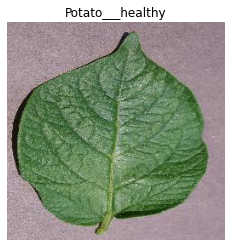

In [9]:
img=view_random_image('Data/train/', class_names[2])

### Need to do Data Preparation and augmentation for model training  

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define directory paths
train_dir = '/content/Data/train'
valid_dir = '/content/Data/val'
test_dir = '/content/Data/test'

# Create ImageDataGenerator training instance
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=0.2,
                                             shear_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             horizontal_flip=True)

# Create ImageDataGenerator validation instance
valid_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator test instance
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                                         target_size=(256,256),
                                                         class_mode='binary',
                                                         batch_size=32)

valid_data = valid_datagen.flow_from_directory(directory=valid_dir,
                                               target_size=(256,256),
                                               class_mode='binary',
                                               batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             class_mode='binary',
                                             batch_size=32)

Found 1721 images belonging to 3 classes.
Found 215 images belonging to 3 classes.
Found 216 images belonging to 3 classes.


### Visualize Train_data

In [11]:
# Total number of images, labels in a single train_data batch
images, labels = train_data.next()
len(images), len(labels) 

(32, 32)

In [12]:
# Total number of batches
len(train_data)

54

In [13]:
# Visualize first image and its shape
images[0], images[0].shape

(array([[[0.5605883 , 0.5135295 , 0.52921575],
         [0.5606552 , 0.51359636, 0.5292826 ],
         [0.560722  , 0.5136632 , 0.52934945],
         ...,
         [0.5474504 , 0.5043132 , 0.51999944],
         [0.5497269 , 0.50658965, 0.5222759 ],
         [0.5451481 , 0.5020108 , 0.5176971 ]],
 
        [[0.5572549 , 0.5101961 , 0.52588236],
         [0.5571212 , 0.5100624 , 0.52574867],
         [0.5569875 , 0.5099287 , 0.525615  ],
         ...,
         [0.53567946, 0.49254218, 0.5082285 ],
         [0.5346601 , 0.49152288, 0.5072091 ],
         [0.5303312 , 0.48719394, 0.5028802 ]],
 
        [[0.49351162, 0.44645277, 0.46213904],
         [0.49347514, 0.44641632, 0.4621026 ],
         [0.4934387 , 0.44637987, 0.46206614],
         ...,
         [0.54217   , 0.4990327 , 0.514719  ],
         [0.54179645, 0.49865916, 0.51434547],
         [0.54204786, 0.49891064, 0.5145969 ]],
 
        ...,
 
        [[0.6156863 , 0.60784316, 0.627451  ],
         [0.6156863 , 0.60784316, 0.62745

### Visualize Training Image randomly

Showing image number: 28


(-0.5, 255.5, 255.5, -0.5)

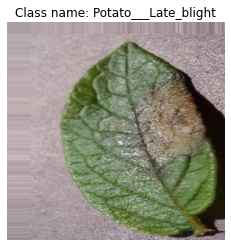

In [14]:
random_number = random.randint(0,31)
print("Showing image number: {}".format(random_number))
plt.imshow(images[random_number])
plt.title("Class name: " + class_names[int(labels[random_number])])
plt.axis(False)

### Create Model

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import Sequential

model = Sequential([
                    Conv2D(32,3,activation="relu", input_shape=(256,256,3)),
                    MaxPool2D(pool_size=2),
                    Conv2D(64,3,activation="relu", input_shape=(256,256,3)),
                    MaxPool2D(pool_size=2),
                    Conv2D(64,3,activation="relu", input_shape=(256,256,3)),
                    MaxPool2D(pool_size=2),
                    Conv2D(64,3,activation="relu", input_shape=(256,256,3)),
                    MaxPool2D(pool_size=2),
                    Conv2D(64,3,activation="relu", input_shape=(256,256,3)),
                    MaxPool2D(pool_size=2),
                    Conv2D(64,3,activation="relu", input_shape=(256,256,3)),
                    MaxPool2D(pool_size=2),
                    Flatten(),
                    Dense(64, activation="relu"),
                    Dense(3, activation="softmax")
                    ])

model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer=Adam(),
              metrics=["accuracy"])

history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    validation_data=valid_data,
                    validation_steps=len(valid_data))

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


54/54 [==============================] - 40s 469ms/step - loss: 0.9114 - accuracy: 0.4869 - val_loss: 0.8916 - val_accuracy: 0.4977
Epoch 2/10
54/54 [==============================] - 25s 461ms/step - loss: 0.8041 - accuracy: 0.6200 - val_loss: 0.6938 - val_accuracy: 0.7814
Epoch 3/10
54/54 [==============================] - 26s 484ms/step - loss: 0.6150 - accuracy: 0.7397 - val_loss: 0.4567 - val_accuracy: 0.8279
Epoch 4/10
54/54 [==============================] - 25s 457ms/step - loss: 0.4920 - accuracy: 0.7833 - val_loss: 0.2680 - val_accuracy: 0.9209
Epoch 5/10
54/54 [==============================] - 25s 458ms/step - loss: 0.4504 - accuracy: 0.8129 - val_loss: 0.4596 - val_accuracy: 0.8047
Epoch 6/10
54/54 [==============================] - 25s 456ms/step - loss: 0.4709 - accuracy: 0.8042 - val_loss: 0.2805 - val_accuracy: 0.9070
Epoch 7/10
54/54 [==============================] - 25s 471ms/step - loss: 0.3675 - accuracy: 0.8530 - val_loss: 0.1957 - val_accuracy: 0.9395
Epoch 8/10

In [16]:
model.evaluate(test_data)

7/7 [==============================] - 1s 122ms/step - loss: 0.2412 - accuracy: 0.9120


[0.241171732544899, 0.9120370149612427]

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

### Plot training curves

In [18]:
def plot_loss_curves(history):
  """
  Return separate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss curves
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy curves
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

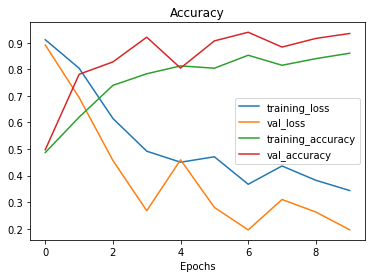

In [19]:
plot_loss_curves(history)

### Do some predictions

Actual Label: Potato___Late_blight
Image Shape; (32, 256, 256, 3)
Predicted Label: Potato___Late_blight


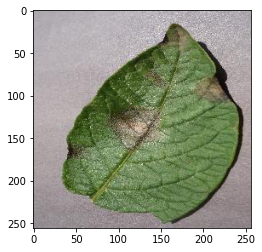

In [20]:
images, labels = test_data.next()
first_image = images[0]
first_label = labels[0]

plt.imshow(first_image)
print('Actual Label: {}'.format(class_names[int(first_label)]))
print('Image Shape; {}'.format(images.shape))

pred_labels = model.predict(images)
print('Predicted Label: {}'.format(class_names[np.argmax(pred_labels[0])])) 

### Save the model

In [25]:
folder_name = 'model'
model_version = 1
model.save("/content/model/a.h5", overwrite=True)

In [26]:
model_version = 2
model.save("/content/model/b.h5", overwrite=True)

In [27]:
model_version = 3
model.save("/content/model/c.h5", overwrite=True)

In [28]:
!zip -r /content/model.zip /content/model/
from google.colab import files
files.download('/content/model.zip')

updating: content/model/ (stored 0%)
updating: content/model/1/ (stored 0%)
updating: content/model/1/variables/ (stored 0%)
updating: content/model/1/variables/variables.index (deflated 72%)
updating: content/model/1/variables/variables.data-00000-of-00001 (deflated 6%)
updating: content/model/1/assets/ (stored 0%)
updating: content/model/1/keras_metadata.pb (deflated 94%)
updating: content/model/1/saved_model.pb (deflated 89%)
updating: content/model/3/ (stored 0%)
updating: content/model/3/variables/ (stored 0%)
updating: content/model/3/variables/variables.index (deflated 72%)
updating: content/model/3/variables/variables.data-00000-of-00001 (deflated 6%)
updating: content/model/3/assets/ (stored 0%)
updating: content/model/3/keras_metadata.pb (deflated 94%)
updating: content/model/3/saved_model.pb (deflated 90%)
updating: content/model/2/ (stored 0%)
updating: content/model/2/variables/ (stored 0%)
updating: content/model/2/variables/variables.index (deflated 72%)
updating: conten

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load and predict the model

Actual Label: Potato___Early_blight
Image Shape; (32, 256, 256, 3)
Predicted Label: Potato___Early_blight


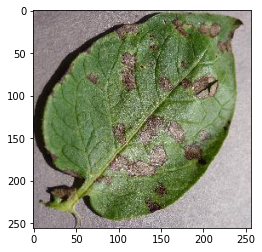

In [29]:
loaded_h5_model = tf.keras.models.load_model('/content/model/a.h5')
images, labels = test_data.next()
first_image = images[0]
first_label = labels[0]

plt.imshow(first_image)
print('Actual Label: {}'.format(class_names[int(first_label)]))
print('Image Shape; {}'.format(images.shape))

pred_labels = loaded_h5_model.predict(images)
print('Predicted Label: {}'.format(class_names[np.argmax(pred_labels[0])]))